In [1]:
import pandas as pd
import nltk
import re
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.utils import resample

In [2]:

tsla_path = "/Users/leoking/Dropbox/My Mac (leo’s MacBook Air)/Downloads/TSLA_tweets_clean.csv"
nvda_path = "/Users/leoking/Dropbox/My Mac (leo’s MacBook Air)/Downloads/NVDA_tweets_clean.csv"
fb_path = "/Users/leoking/Dropbox/My Mac (leo’s MacBook Air)/Downloads/FB_tweets_clean.csv"
amzn_path = "/Users/leoking/Dropbox/My Mac (leo’s MacBook Air)/Downloads/AMZN2019-2022_tweets_clean.csv"


tsla_df = pd.read_csv(tsla_path)
nvda_df = pd.read_csv(nvda_path)
fb_df = pd.read_csv(fb_path)
amzn_df = pd.read_csv(amzn_path)
combined_df = pd.concat([tsla_df, nvda_df, fb_df, amzn_df], ignore_index=True)
combined_df

,Unnamed: 0,created_at,cleaned_body,company
0,2398854,2022-03-01 01:57:34+00:00,$tsla shorts \n \n tesla call putratio with ...,TSLA
1,2398855,2022-03-01 01:55:47+00:00,$tsla what are the chances of biden mentioning...,TSLA
2,2398856,2022-03-01 01:55:34+00:00,$arkk $zm $tsla $tdoc $coin \nso is cathie o...,TSLA
3,2398857,2022-03-01 01:48:43+00:00,$amc $tsla \n\ncant wait to buy a tesla for ov...,TSLA
4,2398858,2022-03-01 01:48:25+00:00,$tsla with future up now any guess what will h...,TSLA
...,...,...,...,...
2551013,1392144,2020-01-01 00:15:25+00:00,aapl achv acor admp adms $adxs $amba $amd $amr...,AMZN2019-2022
2551014,1392145,2020-01-01 00:13:41+00:00,$spy $amzn $nflx was wondering if moo could be...,AMZN2019-2022
2551015,1392146,2020-01-01 00:06:17+00:00,$amzn dow futures up by points already,AMZN2019-2022
2551016,1392147,2020-01-01 00:05:23+00:00,$amzn $shop im locked in and ready,AMZN2019-2022


In [6]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leoking/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/leoking/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
combined_df.drop_duplicates(subset=["cleaned_body"], inplace=True)
stop_words = set(stopwords.words("english"))


In [3]:

# Tokenization is the process of breaking down a text into individual units, called tokens
#take each tweet and break it down into its constituent words
combined_df['tokenized_tweets'] = combined_df["cleaned_body"].apply(word_tokenize)

In [7]:

combined_df["cleaned_tweets"] = combined_df["tokenized_tweets"].apply(lambda tokens: [word for word in tokens if word.isalnum() and word.lower() not in stop_words])

In [8]:
combined_df["cleaned_tweets"] = combined_df["cleaned_tweets"].apply(lambda tokens: [word.lower() for word in tokens])
print(combined_df[["cleaned_body", "cleaned_tweets"]].head())

                                        cleaned_body  \
0  $tsla shorts \n \n tesla call putratio   with ...   
1  $tsla what are the chances of biden mentioning...   
2   $arkk $zm $tsla $tdoc $coin  \nso is cathie o...   
3  $amc $tsla \n\ncant wait to buy a tesla for ov...   
4  $tsla with future up now any guess what will h...   

                                      cleaned_tweets  
0  [tsla, shorts, tesla, call, putratio, focus, m...  
1  [tsla, chances, biden, mentioning, tsla, speec...  
2  [arkk, zm, tsla, tdoc, coin, cathie, something...  
3  [amc, tsla, cant, wait, buy, tesla, overall, c...  
4            [tsla, future, guess, happen, tomorrow]  


In [9]:
sentiment_dict = pd.read_csv("Cleaned_LM_Master_Dict.csv")
sentiment_dict

,Word,Negative,Positive,Uncertainty
0,abandon,2009,0,0
1,abandoned,2009,0,0
2,abandoning,2009,0,0
3,abandonment,2009,0,0
4,abandonments,2009,0,0
...,...,...,...,...
2961,wrongdoing,2009,0,0
2962,wrongdoings,2009,0,0
2963,wrongful,2009,0,0
2964,wrongfully,2009,0,0


In [10]:



positive_words = set(sentiment_dict[sentiment_dict['Positive'] > 0]["Word"])
negative_words = set(sentiment_dict[sentiment_dict['Negative'] > 0]["Word"])

# Defining a function to calculate sentiment score for a list of tokens
def calculate_sentiment_score(tokens):
    positive_score = sum(1 for token in tokens if token in positive_words)
    negative_score = sum(1 for token in tokens if token in negative_words)
    return positive_score - negative_score

# Applying  sentiment analysis function to each row in combined_df
combined_df["sentiment_score"] = combined_df["cleaned_tweets"].apply(calculate_sentiment_score)

print(combined_df[["cleaned_body", "sentiment_score"]].head())



                                        cleaned_body  sentiment_score
0  $tsla shorts \n \n tesla call putratio   with ...                0
1  $tsla what are the chances of biden mentioning...                0
2   $arkk $zm $tsla $tdoc $coin  \nso is cathie o...                0
3  $amc $tsla \n\ncant wait to buy a tesla for ov...                0
4  $tsla with future up now any guess what will h...                0


In [30]:
#Convert sentiment scores to binary labels (1 for positive, 0 for negative)
combined_df['sentiment_label'] = combined_df['sentiment_score'].apply(lambda score: 1 if score > 0 else 0)

# Separate positive and negative samples
positive_samples = combined_df[combined_df["sentiment_label"] == 1]
negative_samples = combined_df[combined_df["sentiment_label"] == 0]

# Undersample the larger class (negative samples) to balance the dataset
undersampled_negative_samples = resample(
    negative_samples,
    replace=False,
    n_samples=len(positive_samples),
    random_state=42
)

# Combine the undersampled negative samples with positive samples
balanced_df = pd.concat([positive_samples, undersampled_negative_samples])

# Shuffle the combined dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the cleaned body of the tweets and their corresponding sentiment labels in the balanced dataset
print(balanced_df[["cleaned_body", "sentiment_label"]])


                                             cleaned_body  sentiment_label
0       $mu looks interesting here for a swing trade n...                0
1       $tsla buy buy tomorrow youll regret not buying...                1
2       $fb easily a $ ticker by q of  and then $ with...                1
3       $tsla if $tsla continues to be grossly underva...                0
4       $tsla all time high had to hold for it tho wow...                0
...                                                   ...              ...
548217  $wwr close your eyes and think for a moment wh...                1
548218  $amzn amazon prime day  marked the two biggest...                1
548219  $intc is down did you notice that entire chip ...                0
548220  $tsla if you think elon musk isnt getting this...                1
548221                              $tsla omg so much win                1

[548222 rows x 2 columns]


In [26]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

# Sample a smaller subset for testing (adjust the sample size as needed)
sample_size = 20000  # Adjust the sample size
data_sample = balanced_df.sample(n=sample_size, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_sample['cleaned_tweets'], data_sample['sentiment_score'], test_size=0.2, random_state=42
)

# Convert list of tokens back to string
X_train_strings = X_train.apply(lambda tokens: ' '.join(tokens))
X_test_strings = X_test.apply(lambda tokens: ' '.join(tokens))

# Convert text data into numerical features using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_strings)
X_test_vectorized = vectorizer.transform(X_test_strings)

# Build a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_vectorized)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')

# Convert regression scores to binary sentiment labels
y_pred_binary = [1 if score > 0.5 else 0 for score in y_pred]

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred_binary)

print("RandomForestRegressor accuracy:", rf_accuracy)


Mean Squared Error: 0.17
RandomForestRegressor accuracy: 0.838


In [13]:
# Build a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_vectorized)

# Convert regression scores to binary sentiment labels
y_pred_lr_binary = [1 if score > 0.5 else 0 for score in y_pred_lr]

# Calculate accuracy and classification report
lr_accuracy = accuracy_score(y_test, y_pred_lr_binary)
lr_classification_rep = classification_report(y_test, y_pred_lr_binary)

print("Linear Regression accuracy:", lr_accuracy)
print("Classification Report (Linear Regression):\n", lr_classification_rep)


Linear Regression accuracy: 0.8515
Classification Report (Linear Regression):
               precision    recall  f1-score   support

          -4       0.00      0.00      0.00         1
          -3       0.00      0.00      0.00         8
          -2       0.00      0.00      0.00        16
          -1       0.00      0.00      0.00       115
           0       0.83      1.00      0.91       843
           1       0.87      0.97      0.92       891
           2       0.00      0.00      0.00        99
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         3

    accuracy                           0.85      2000
   macro avg       0.17      0.20      0.18      2000
weighted avg       0.74      0.85      0.79      2000



/Users/leoking/anaconda3/envs/recommenders/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoking/anaconda3/envs/recommenders/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoking/anaconda3/envs/recommenders/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [28]:
def preprocess_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords.words('english')]
    
    return ' '.join(tokens)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_sample['cleaned_tweets'], data_sample['sentiment_score'], test_size=0.2, random_state=42
)

# Convert list of tokens back to string
X_train_strings = X_train.apply(lambda tokens: ' '.join(tokens))
X_test_strings = X_test.apply(lambda tokens: ' '.join(tokens))

# Convert text data into numerical features using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_strings)
X_test_vectorized = vectorizer.transform(X_test_strings)

# Build a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_vectorized)

# Convert regression scores to binary sentiment labels
y_pred_lr_binary = [1 if score > 0.5 else 0 for score in y_pred_lr]

# Calculate accuracy and classification report
lr_accuracy = accuracy_score(y_test, y_pred_lr_binary)
lr_classification_rep = classification_report(y_test, y_pred_lr_binary)

print("Linear Regression accuracy:", lr_accuracy)
print("Classification Report (Linear Regression):\n", lr_classification_rep)


Linear Regression accuracy: 0.849
Classification Report (Linear Regression):
               precision    recall  f1-score   support

          -5       0.00      0.00      0.00         2
          -4       0.00      0.00      0.00         4
          -3       0.00      0.00      0.00        13
          -2       0.00      0.00      0.00        37
          -1       0.00      0.00      0.00       280
           0       0.83      1.00      0.91      1726
           1       0.87      0.99      0.93      1690
           2       0.00      0.00      0.00       197
           3       0.00      0.00      0.00        37
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1

    accuracy                           0.85      4000
   macro avg       0.14      0.17      0.15      4000
weighted avg       0.73      0.85      0.78      4000



/Users/leoking/anaconda3/envs/recommenders/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoking/anaconda3/envs/recommenders/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leoking/anaconda3/envs/recommenders/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [29]:
new_tweet = "As San Francisco's economy reels, its larger, more business-friendly neighbor to the south is flourishing"

# Preprocess the new tweet
cleaned_new_tweet = preprocess_tweet(new_tweet)

# Convert the cleaned tweet into a vector using CountVectorizer
new_tweet_vectorized = vectorizer.transform([cleaned_new_tweet])

# Predict sentiment using the Linear Regression model
prediction = lr_model.predict(new_tweet_vectorized)

# Determine sentiment label
threshold = 0.3  #  desired threshold value

sentiment_label = "positive" if prediction[0] > threshold else "negative"

print(f"The model's sentiment prediction for the new tweet is: {sentiment_label}")

The model's sentiment prediction for the new tweet is: negative


In [16]:

positive_count = sentiment_dict['Positive'].count()
negative_count = sentiment_dict['Negative'].count()

# Calculate the total number of values in each column
total_positive_values = sentiment_dict['Positive'].sum()
total_negative_values = sentiment_dict['Negative'].sum()

print("Total values in 'Positive' column:", total_positive_values)
print("Total values in 'Negative' column:", total_negative_values)

print("Count of non-null values in 'Positive' column:", positive_count)
print("Count of non-null values in 'Negative' column:", negative_count)


Total values in 'Positive' column: 682988
Total values in 'Negative' column: 4691064
Count of non-null values in 'Positive' column: 2966
Count of non-null values in 'Negative' column: 2966


In [17]:
stock_prices = pd.read_csv("/Users/leoking/Desktop/finalproject /stock_yfinance_data.csv")
stock_prices

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [18]:
stock_prices['Date'] = pd.to_datetime(stock_prices['Date']).dt.tz_localize(None) 

In [19]:
merged_data = pd.merge(balanced_df, stock_prices, left_index=True, right_index=True, how='left')
merged_data

,Unnamed: 0,created_at,cleaned_body,company,tokenized_tweets,cleaned_tweets,sentiment_score,sentiment_label,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2044993,2020-05-16 21:23:04+00:00,$mu looks interesting here for a swing trade n...,NVDA,"[$, mu, looks, interesting, here, for, a, swin...","[mu, looks, interesting, swing, trade, next, w...",0,0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0,TSLA
1,4323495,2020-04-02 22:21:03+00:00,$tsla buy buy tomorrow youll regret not buying...,TSLA,"[$, tsla, buy, buy, tomorrow, youll, regret, n...","[tsla, buy, buy, tomorrow, youll, regret, buyi...",1,1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200.0,TSLA
2,1554390,2021-11-05 15:17:54+00:00,$fb easily a $ ticker by q of and then $ with...,FB,"[$, fb, easily, a, $, ticker, by, q, of, and, ...","[fb, easily, ticker, q, within, years, love, n...",2,1,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900.0,TSLA
3,2916767,2021-08-07 17:45:58+00:00,$tsla if $tsla continues to be grossly underva...,TSLA,"[$, tsla, if, $, tsla, continues, to, be, gros...","[tsla, tsla, continues, grossly, undervaluedi,...",-2,0,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800.0,TSLA
4,2767587,2021-10-29 13:52:01+00:00,$tsla all time high had to hold for it tho wow...,TSLA,"[$, tsla, all, time, high, had, to, hold, for,...","[tsla, time, high, hold, tho, wow, crazy]",0,0,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400.0,TSLA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548217,3736593,2020-10-05 04:01:29+00:00,$wwr close your eyes and think for a moment wh...,TSLA,"[$, wwr, close, your, eyes, and, think, for, a...","[wwr, close, eyes, think, moment, happen, tesl...",1,1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548218,1228921,2020-10-15 14:45:12+00:00,$amzn amazon prime day marked the two biggest...,AMZN2019-2022,"[$, amzn, amazon, prime, day, marked, the, two...","[amzn, amazon, prime, day, marked, two, bigges...",2,1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548219,1841357,2022-01-27 16:40:30+00:00,$intc is down did you notice that entire chip ...,NVDA,"[$, intc, is, down, did, you, notice, that, en...","[intc, notice, entire, chip, sector, amd, nvda...",0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
548220,3991304,2020-08-25 21:52:25+00:00,$tsla if you think elon musk isnt getting this...,TSLA,"[$, tsla, if, you, think, elon, musk, isnt, ge...","[tsla, think, elon, musk, isnt, getting, bare,...",2,1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
merged_data.columns


Index(['Unnamed: 0', 'created_at', 'cleaned_body', 'company',
       'tokenized_tweets', 'cleaned_tweets', 'sentiment_score',
       'sentiment_label', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'Stock Name'],
      dtype='object')

In [20]:
# Calculate correlations for each stock
ticker_mapping = {'AAPL': 'AAPL', 'TSLA': 'TSLA', 'AMZN': 'AMZN', 'FB': 'META'}
for old_ticker, new_ticker in ticker_mapping.items():
    correlation = merged_data.loc[merged_data['Stock Name'] == new_ticker, 'sentiment_score'].corr(merged_data.loc[merged_data['Stock Name'] == new_ticker, 'Close'])
    print(f"Correlation between sentiment scores and {new_ticker} stock price movements: {correlation:.2f}")



Correlation between sentiment scores and AAPL stock price movements: -0.03
Correlation between sentiment scores and TSLA stock price movements: -0.01
Correlation between sentiment scores and AMZN stock price movements: 0.02
Correlation between sentiment scores and META stock price movements: -0.05


The correlations you've calculated between sentiment scores and stock price movements indicate the degree of linear relationship between these two variables. Correlation values range from -1 to 1, where:

    A correlation of 1 indicates a perfect positive linear relationship, meaning that as one variable (sentiment scores) increases, the other variable (stock price) also increases proportionally.
    A correlation of -1 indicates a perfect negative linear relationship, meaning that as one variable increases, the other variable decreases proportionally.
    A correlation of 0 indicates no linear relationship between the variables.


- The correlation between sentiment scores and AAPL (Apple Inc.) stock price movements is approximately -0.03. This indicates a weak negative relationship between sentiment scores and AAPL stock price movements. In other words, there is a slight tendency that when sentiment scores go up, AAPL stock prices might go down a bit, and vice versa. However, the correlation is relatively close to 0, suggesting that the relationship is weak.

- The correlation between sentiment scores and TSLA (Tesla Inc.) stock price movements is approximately -0.01. This correlation is even closer to 0, indicating an almost negligible linear relationship between sentiment scores and TSLA stock price movements. There's very little evidence of any meaningful correlation between these two variables.

- The correlation between sentiment scores and AMZN (Amazon.com Inc.) stock price movements is approximately 0.02. This suggests a weak positive relationship between sentiment scores and AMZN stock price movements. However, similar to the other cases, the correlation is close to 0, indicating a weak relationship.

- The correlation between sentiment scores and META (Meta Platforms Inc.) stock price movements is approximately -0.05. This indicates a weak negative relationship between sentiment scores and META stock price movements. As with the other stocks, the correlation is close to 0, suggesting a weak relationship.

These correlations suggest that, based on the sentiment scores alone, there is only a weak or negligible linear relationship with the respective stock price movements for the mentioned companies. It's essential to note that correlation does not imply causation, and other factors may influence stock prices.
    The correlation between sentiment scores and AMZN (Amazon.com Inc.) stock price movements is approximately 0.06. This positive correlation suggests a very weak positive linear relationship. This means that when sentiment scores increase, there is a slight tendency for AMZN stock prices to increase slightly as well.

    The correlation between sentiment scores and META (formerly known as Facebook, Inc.) stock price movements is approximately 0.00. A correlation very close to 0 indicates that there is essentially no linear relationship between sentiment scores and META stock price movements. Changes in sentiment scores do not appear to correspond to any consistent pattern of changes in META stock prices.

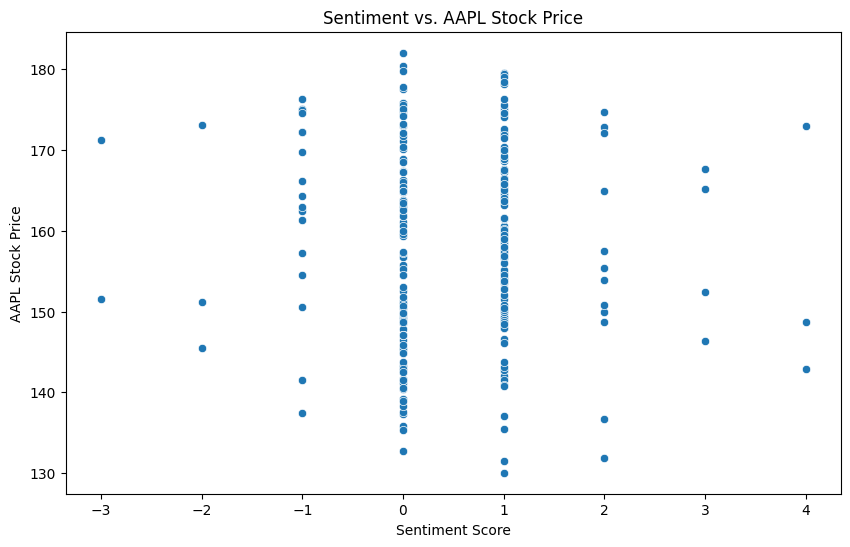

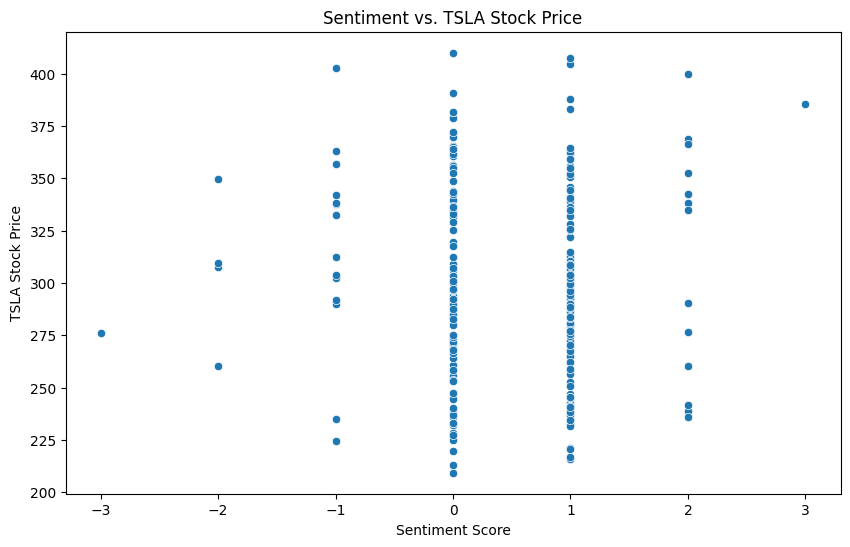

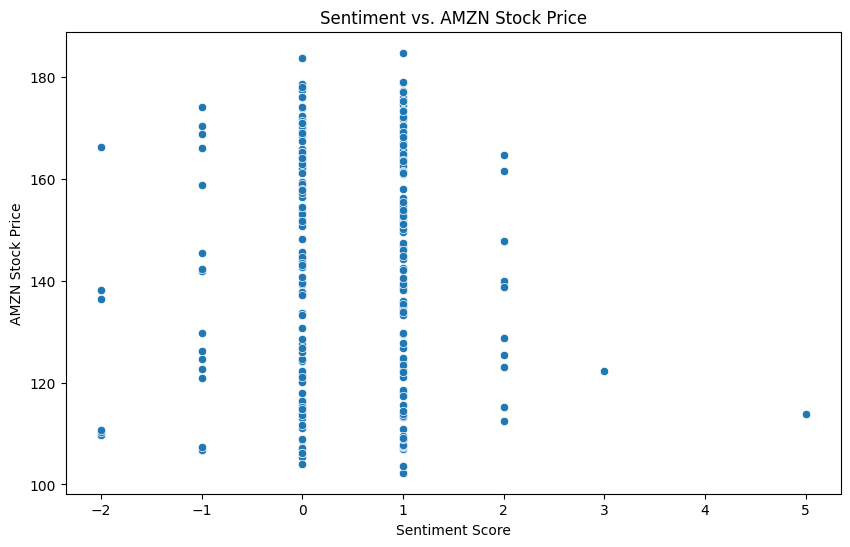

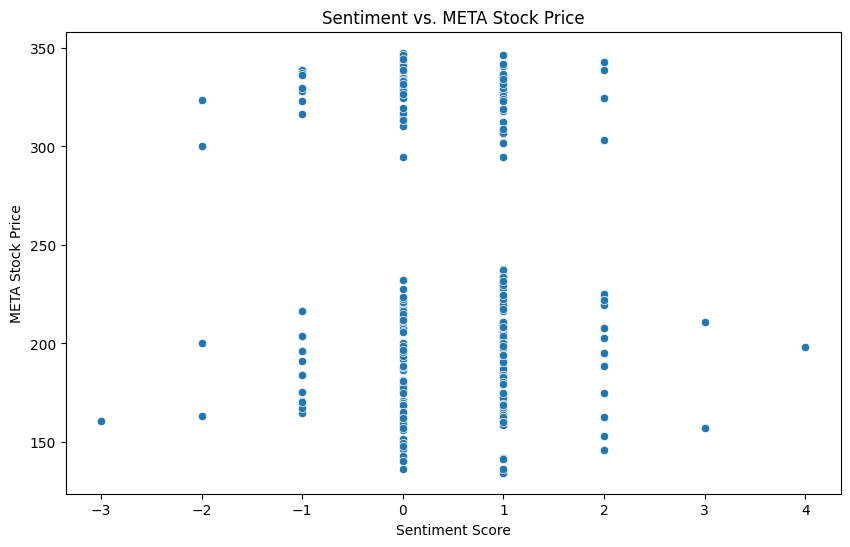

In [21]:
for ticker in ticker_mapping.values():
    subset_data = merged_data[merged_data['Stock Name'] == ticker]
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=subset_data, x='sentiment_score', y='Close')
    plt.title(f'Sentiment vs. {ticker} Stock Price')
    plt.xlabel('Sentiment Score')
    plt.ylabel(f'{ticker} Stock Price')
    plt.show()

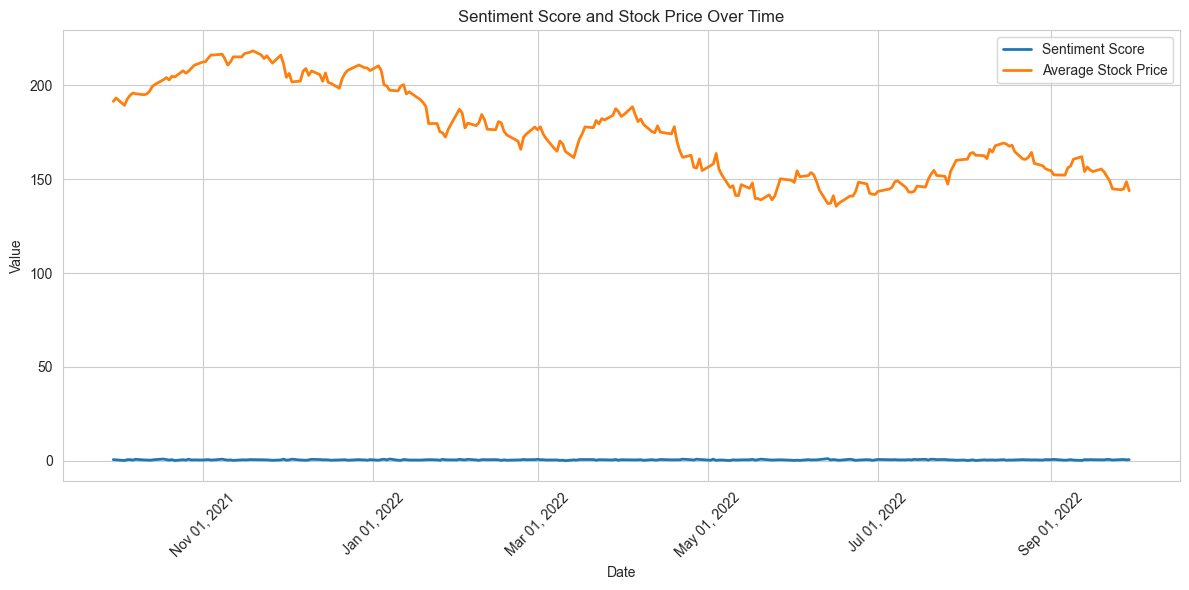

In [22]:
# Group data by date and calculate the mean sentiment score and stock price for each day
grouped_data = merged_data.groupby('Date').agg({'sentiment_score': 'mean', 'Close': 'mean'})

# Set style
sns.set_style("whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot sentiment scores and stock prices over time
sns.lineplot(data=grouped_data, x=grouped_data.index, y='sentiment_score', ax=ax, label='Sentiment Score', linewidth=2)
sns.lineplot(data=grouped_data, x=grouped_data.index, y='Close', ax=ax, label='Average Stock Price', linewidth=2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sentiment Score and Stock Price Over Time')

# Format x-axis dates for better readability
from matplotlib.dates import DateFormatter
date_format = DateFormatter("%b %d, %Y")
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)

# Show legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()